## Week 5 Capstone Work

For Week 5, include concepts such as support vector machines, the kernel trick, and regularization for support vector machines.

In [1]:
# Imports
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score, GridSearchCV, cross_val_predict
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
from matplotlib.colors import ListedColormap

In [2]:
# Read in wr data and convert injury to binary
wr = pd.read_csv('data/cleaned/wr_eng.csv', sep=',', header=0)

wr['Injured'] = (wr['Injury_Duration'] > 0).astype(float)

wr = wr.drop(columns=['Injury_Duration'])
wr.head()

,Length,Distance,DirChanges,Max_S,Max_A,Temperature,Precipitation,FieldType_Natural,PlayType_Extra Point,PlayType_Field Goal,...,PlayType_Punt Not Returned,PlayType_Punt Returned,PlayType_Rush,Length_sq,Distance_sq,DirChanges_sq,Max_S_sq,Max_A_sq,Temperature_sq,Injured
0,35.3,52.89,35.0,7.59,0.62,39.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1246.09,2797.3521,1225.0,57.6081,0.3844,1521.0,1.0
1,43.9,61.42,13.0,7.34,1.06,70.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1927.21,3772.4164,169.0,53.8756,1.1236,4900.0,1.0
2,29.4,38.52,14.0,7.37,0.89,44.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,864.36,1483.7904,196.0,54.3169,0.7921,1936.0,1.0
3,18.9,47.06,2.0,7.75,0.36,76.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,357.21,2214.6436,4.0,60.0625,0.1296,5776.0,1.0
4,18.7,73.23,0.0,9.48,0.41,48.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,349.69,5362.6329,0.0,89.8704,0.1681,2304.0,1.0


In [3]:
# XY split
X_wr = wr.drop(columns=['Injured']).copy()
y_wr = wr['Injured'].copy()

### SVM

In [4]:
wr_svm_pipeline = Pipeline([('scaler', StandardScaler()),
    ('regressor', SVC(random_state=42))
])

wr_svm_params = {'regressor__C': [1, 5], 'regressor__kernel': ['linear', 'poly', 'rbf']}

wr_svm_gs = GridSearchCV(estimator=wr_svm_pipeline, param_grid=wr_svm_params, cv=RepeatedKFold(n_splits=5, n_repeats=2, random_state=42), scoring='neg_mean_squared_error')

wr_svm_gs.fit(X_wr, y_wr)

print("SVM Params:", wr_svm_gs.best_params_)
print("RMSE:", np.sqrt(-wr_svm_gs.best_score_))

SVM Params: {'regressor__C': 5, 'regressor__kernel': 'rbf'}
RMSE: 0.1492840054584358


In [5]:
results_wr = pd.DataFrame(wr_svm_gs.cv_results_)
results_wr['RMSE'] = np.sqrt(-results_wr['mean_test_score'])
results_wr[['param_regressor__C', 'param_regressor__kernel', 'RMSE']]

,param_regressor__C,param_regressor__kernel,RMSE
0,1,linear,0.218109
1,1,poly,0.165040
2,1,rbf,0.162715
3,5,linear,0.216355
4,5,poly,0.160950
5,5,rbf,0.149284


In [6]:
wr_svm_pipeline = Pipeline([('scaler', StandardScaler()),
    ('regressor', SVC(random_state=42))
])

wr_svm_params = {'regressor__C': [float(i) for i in range(90, 150, 5)], 'regressor__kernel': ['rbf']}

wr_svm_gs = GridSearchCV(estimator=wr_svm_pipeline, param_grid=wr_svm_params, cv=RepeatedKFold(n_splits=5, n_repeats=2, random_state=42), scoring='neg_mean_squared_error')

wr_svm_gs.fit(X_wr, y_wr)

print("SVM Params:", wr_svm_gs.best_params_)
print("RMSE:", np.sqrt(-wr_svm_gs.best_score_))

SVM Params: {'regressor__C': 135.0, 'regressor__kernel': 'rbf'}
RMSE: 0.09385906354489058


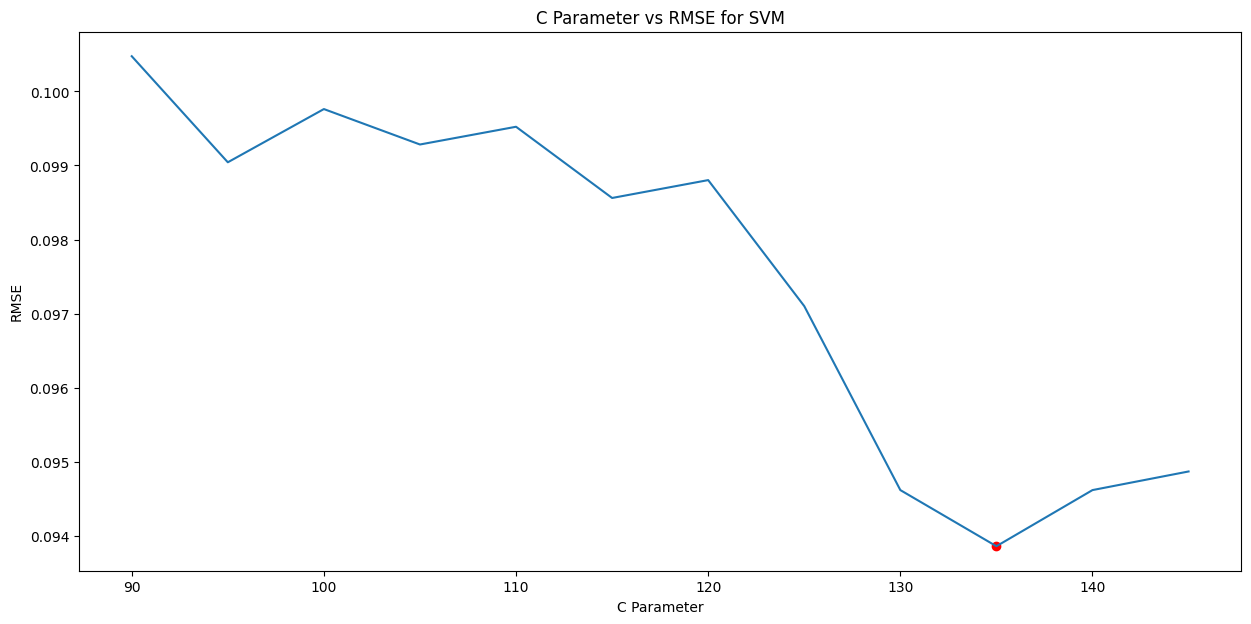

In [7]:
results_wr = pd.DataFrame(wr_svm_gs.cv_results_)
results_wr['RMSE'] = np.sqrt(-results_wr['mean_test_score'])
# results_wr[['param_regressor__C', 'param_regressor__kernel', 'RMSE']]

plt.figure(figsize=(15, 7))
plt.plot(results_wr['param_regressor__C'], results_wr['RMSE'])
plt.scatter(wr_svm_gs.best_params_['regressor__C'], np.sqrt(-wr_svm_gs.best_score_), c='r')
plt.xlabel('C Parameter')
plt.ylabel('RMSE')
plt.title('C Parameter vs RMSE for SVM')
plt.show()

In [8]:
X_wr_train, X_wr_test, y_wr_train, y_wr_test = train_test_split(X_wr, y_wr, test_size=.25, random_state=42)

scores = {'C': [], 'Accuracy': []}
for i in [float(i) for i in [0.001, 0.01, 0.1, 1, 10, 100, 1000]]:
    svc = SVC(kernel='linear', C=i)
    svc.fit(X_wr_train, y_wr_train)

    scores['C'].append(i)
    scores['Accuracy'].append((svc.predict(X_wr_test) == y_wr_test).mean())

conf_matrix = confusion_matrix(y_wr_test, svc.predict(X_wr_test))
pd.DataFrame(scores), conf_matrix

(          C  Accuracy
 0     0.001  0.949333
 1     0.010  0.949333
 2     0.100  0.948190
 3     1.000  0.950095
 4    10.000  0.950095
 5   100.000  0.950095
 6  1000.000  0.950095,
 array([[2487,    5],
        [ 126,    7]]))

In [9]:
X_wr_train, X_wr_test, y_wr_train, y_wr_test = train_test_split(X_wr, y_wr, test_size=.25, random_state=42)

scores = {'C': [], 'Accuracy': []}
for i in [float(i) for i in [0.001, 0.01, 0.1, 1, 10, 100, 1000]]:
    svc = SVC(kernel='rbf', C=i)
    svc.fit(X_wr_train, y_wr_train)

    scores['C'].append(i)
    scores['Accuracy'].append((svc.predict(X_wr_test) == y_wr_test).mean())

conf_matrix = confusion_matrix(y_wr_test, svc.predict(X_wr_test))
pd.DataFrame(scores), conf_matrix

(          C  Accuracy
 0     0.001  0.949333
 1     0.010  0.949333
 2     0.100  0.949333
 3     1.000  0.949333
 4    10.000  0.949333
 5   100.000  0.949333
 6  1000.000  0.960000,
 array([[2491,    1],
        [ 104,   29]]))

In [10]:
X_wr_train, X_wr_test, y_wr_train, y_wr_test = train_test_split(X_wr, y_wr, test_size=.25, random_state=42)

scores = {'C': [], 'Accuracy': []}
for i in [float(i) for i in [0.001, 0.01, 0.1, 1, 10, 100, 1000]]:
    svc = SVC(kernel='poly', C=i)
    svc.fit(X_wr_train, y_wr_train)

    scores['C'].append(i)
    scores['Accuracy'].append((svc.predict(X_wr_test) == y_wr_test).mean())

conf_matrix = confusion_matrix(y_wr_test, svc.predict(X_wr_test))
pd.DataFrame(scores), conf_matrix

(          C  Accuracy
 0     0.001  0.949333
 1     0.010  0.949333
 2     0.100  0.949333
 3     1.000  0.949333
 4    10.000  0.949333
 5   100.000  0.949333
 6  1000.000  0.949333,
 array([[2492,    0],
        [ 133,    0]]))

In [11]:
sum(y_wr_test == 1)

133

I tried, linear, poly, rbf, with wide ranges of C and could never get it to perform better than logistic regression. I could not figure out why, so I decided to scrap this model from any further evaluation.